In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm

df = pd.read_csv("data/prosperLoanData.csv")

--- Raw LoanStatus Distribution ---
LoanStatus
Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: count, dtype: int64


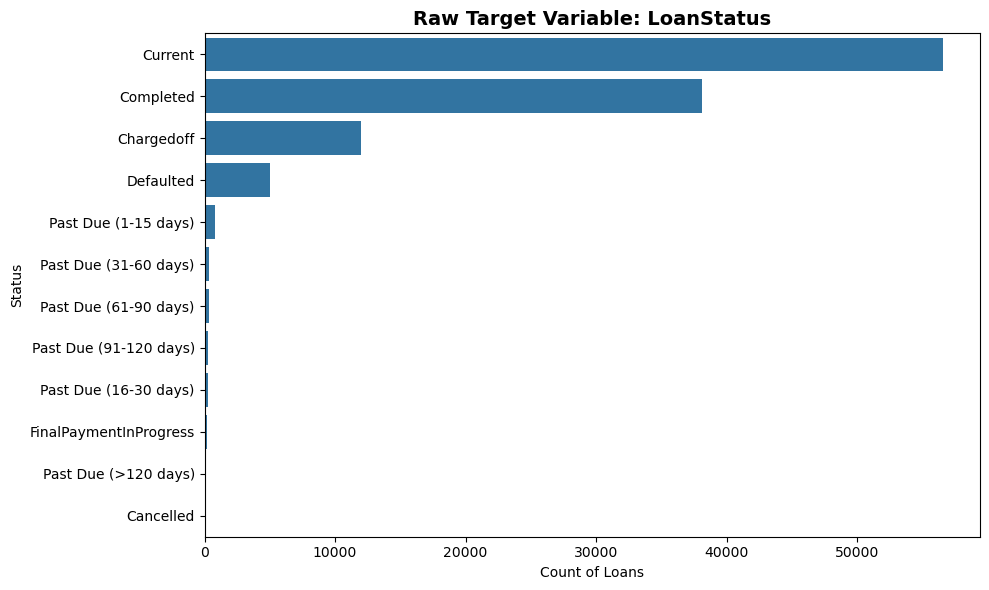

In [2]:
status_counts = df["LoanStatus"].value_counts()

print("--- Raw LoanStatus Distribution ---")
print(status_counts)

plt.figure(figsize=(10, 6))
sns.barplot(y=status_counts.index, x=status_counts.values)
plt.title("Raw Target Variable: LoanStatus", fontsize=14, fontweight="bold")
plt.xlabel("Count of Loans")
plt.ylabel("Status")
plt.tight_layout()
plt.show()

### The Missing Link: Why We Need a Price Elasticity Model

In a standard lending system, banks typically focus on one question: **"Will this customer pay us back?"** (The Probability of Default).

However, to build an **Optimization Engine** that maximizes profit, we must answer a second, equally critical question: **"Will this customer accept our offer?"** (The Probability of Acceptance).

The Price Elasticity / Conversion Model is required for three critical reasons:

#### 1. The Profit Trade-Off
If we only priced based on risk, we would charge every customer the highest possible rate to maximize margin. But as the price increases, the probability of the customer accepting the loan drops.
* **Price too high:** High margin, but 0% conversion = **$0 Profit**.
* **Price too low:** 100% conversion, but negative margin = **Loss**.

The Elasticity Model draws the "Demand Curve" for each customer, allowing the Optimization Engine ("The Brain") to solve the formula:
$$Expected Profit = P(Acceptance|Rate) \times (Revenue - Expected Loss)$$

#### 2. Overcoming "Survival Bias"
Our historical data (LendingClub/Prosper) suffers from **Survival Bias**. It only contains records of loans that were *originated*.
* We see the winners (people who said "Yes").
* We are blind to the losers (people who rejected our offer because it was too expensive).

Without simulating these rejections (via synthetic data) and training a model on them, our engine would incorrectly assume that **every customer accepts every rate**, leading to catastrophic overpricing.

#### 3. Personalization (Elastic vs. Inelastic)
Not all customers react to price changes the same way:
* **Price Sensitive (Elastic):** A borrower with a 750 FICO and low DTI has many options. If you raise their rate by 0.5%, they will leave for a competitor.
* **Price Insensitive (Inelastic):** A borrower with a 640 FICO and high urgent debt has few options. You can raise their rate by 2% without significantly lowering their acceptance probability.

This model identifies *who* is sensitive, allowing us to offer competitive rates to prime borrowers (to win volume) while protecting margins on subprime borrowers.

In [5]:
funded_loans = df[df["LoanStatus"].isin(["Completed", "Current", "Paid"])].copy()

In [ ]:
start_time = time.time()


def generate_rates(actual_rate, lower=0.02, upper=0.02, step=0.0025):
    low = max(0, actual_rate - lower)
    high = actual_rate + upper
    rates = np.arange(low, high + step, step)
    return np.round(rates, 4)


def acceptance_probability(offered_rates, actual_rate, alpha=100, max_prob=0.98):

    # 1. Calculate the decay curve for ALL rates
    sigmoid = 1 / (1 + np.exp(alpha * (offered_rates - actual_rate)))
    decay_curve = 2 * max_prob * sigmoid

    # 2. Apply logic element-wise
    return np.where(offered_rates <= actual_rate, max_prob, decay_curve)


print(f"Generating synthetic data for {len(funded_loans)} loans...")

synthetic_rows = []

for idx, row in tqdm(funded_loans.iterrows(), total=funded_loans.shape[0]):
    actual_rate = row["BorrowerRate"]

    rates = generate_rates(actual_rate)

    probs = acceptance_probability(rates, actual_rate, alpha=100, max_prob=0.98)

    accepts = np.random.binomial(1, probs)

    for r, a in zip(rates, accepts):
        new_row = row.copy()
        new_row["OfferedRate"] = r
        new_row["Accepted"] = int(a)
        synthetic_rows.append(new_row)


synthetic_df = pd.DataFrame(synthetic_rows)
synthetic_df.to_csv("Prosper_Synthetic_Elasticity.csv", index=False)

print("Synthetic dataset created with shape:", synthetic_df.shape)

end_time = time.time()
total_seconds = end_time - start_time
minutes = int(total_seconds // 60)
seconds = int(total_seconds % 60)

print(f"Total execution time: {minutes} minutes {seconds} seconds")

Generating synthetic data for 94650 loans...


100%|██████████| 94650/94650 [19:54<00:00, 79.27it/s]  


Synthetic dataset created with shape: (1650954, 83)
Total execution time: 23 minutes 50 seconds


In [3]:
synthetic_df = pd.read_csv("data/Prosper_Synthetic_Elasticity.csv")


--- Synthetic Data Generation Complete ---
Original Rows: 94650
Synthetic Rows: 1650954 (Expanded by ~9x)

Sample Data (Simulated Rejections):
    BorrowerRate  OfferedRate  Accepted
0         0.1580       0.1380         1
1         0.1580       0.1405         1
2         0.1580       0.1430         1
3         0.1580       0.1455         1
4         0.1580       0.1480         1
..           ...          ...       ...
95        0.1314       0.1289         1
96        0.1314       0.1314         1
97        0.1314       0.1339         0
98        0.1314       0.1364         1
99        0.1314       0.1389         1

[100 rows x 3 columns]


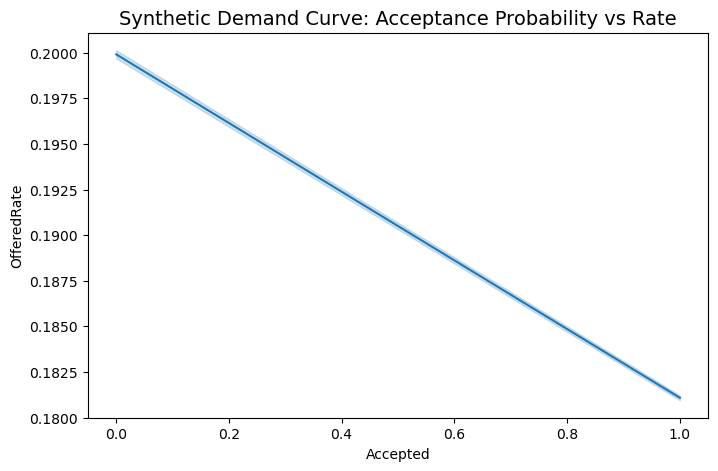

In [6]:
print("\n--- Synthetic Data Generation Complete ---")
print(f"Original Rows: {len(funded_loans)}")
print(f"Synthetic Rows: {len(synthetic_df)} (Expanded by ~9x)")
print("\nSample Data (Simulated Rejections):")
print(synthetic_df[["BorrowerRate", "OfferedRate", "Accepted"]].head(100))

plt.figure(figsize=(8, 5))
sns.lineplot(x="Accepted", y="OfferedRate", data=synthetic_df)
plt.title("Synthetic Demand Curve: Acceptance Probability vs Rate", fontsize=14)
plt.show()

# Univariate Analysis

For the Prosper dataset, the Univariate Analysis serves a slightly different purpose than it did for LendingClub.

For LendingClub (Risk Model), we looked for "**Who is Risky**?" For Prosper (Elasticity Model), we are looking for "**Who is Price Sensitive**?" and "**What is our Offer Distribution**?"

In [7]:
numerical_cols = [
    "OfferedRate",
    "LoanOriginalAmount",
    "StatedMonthlyIncome",
    "DebtToIncomeRatio",
]
categorical_cols = ["Accepted", "ProsperScore", "Term"]

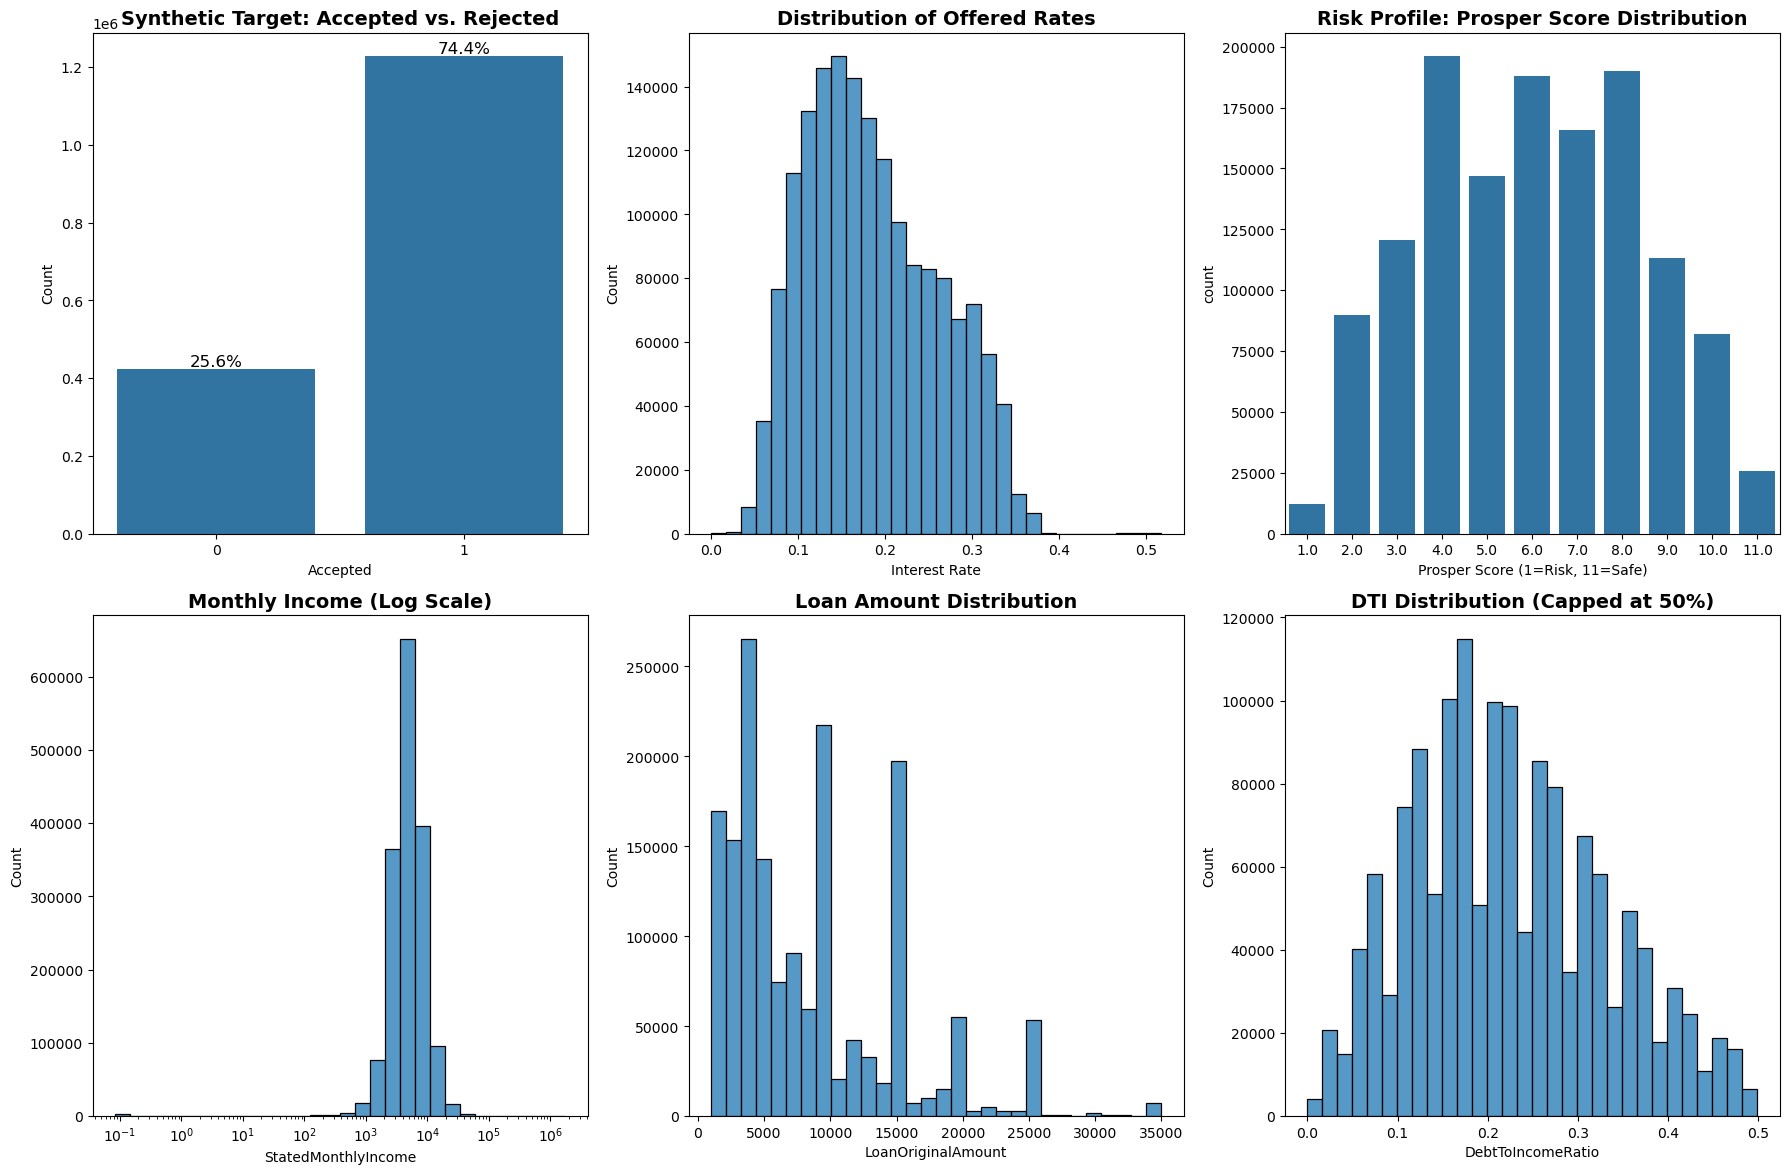

In [8]:
fig = plt.figure(figsize=(18, 12))

ax1 = plt.subplot(2, 3, 1)
sns.countplot(x="Accepted", data=synthetic_df, ax=ax1)
ax1.set_title("Synthetic Target: Accepted vs. Rejected", fontsize=14, fontweight="bold")
ax1.set_ylabel("Count")

total = len(synthetic_df)
for p in ax1.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax1.annotate(percentage, (x, y), ha="center", va="bottom", fontsize=12)


ax2 = plt.subplot(2, 3, 2)
sns.histplot(synthetic_df["OfferedRate"], bins=30, ax=ax2)
ax2.set_title("Distribution of Offered Rates", fontsize=14, fontweight="bold")
ax2.set_xlabel("Interest Rate")


ax3 = plt.subplot(2, 3, 3)
sns.countplot(x="ProsperScore", data=synthetic_df, ax=ax3)
ax3.set_title(
    "Risk Profile: Prosper Score Distribution", fontsize=14, fontweight="bold"
)
ax3.set_xlabel("Prosper Score (1=Risk, 11=Safe)")


ax4 = plt.subplot(2, 3, 4)
sns.histplot(synthetic_df["StatedMonthlyIncome"], bins=30, log_scale=True, ax=ax4)
ax4.set_title("Monthly Income (Log Scale)", fontsize=14, fontweight="bold")


ax5 = plt.subplot(2, 3, 5)
sns.histplot(synthetic_df["LoanOriginalAmount"], bins=30, ax=ax5)
ax5.set_title("Loan Amount Distribution", fontsize=14, fontweight="bold")

ax6 = plt.subplot(2, 3, 6)
sns.histplot(
    synthetic_df[synthetic_df["DebtToIncomeRatio"] < 0.5]["DebtToIncomeRatio"],
    bins=30,
    ax=ax6,
)
ax6.set_title("DTI Distribution (Capped at 50%)", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()

#### **Target Variable – Accepted vs Rejected (Synthetic)**

**Observation**

* Accepted ≈ 74.4%
* Rejected ≈ 25.6%

**Interpretation**

* This is a **realistic acceptance pattern** for an elasticity simulation:

  * OfferedRate ≤ BorrowerRate → fairly high acceptance probability
  * Most synthetic rates lie **near or below** borrower rates → many acceptances
* This matches expected borrower behavior in loan marketplaces:

  * Borrowers prefer lower rates
  * They accept reasonable or improved offers

**Implication**

* This is a **healthy, realistic target distribution** for modelling rate sensitivity.



#### **Offered Rate Distribution**

**Observation**

* Distribution is centered around **≈15–20%**, with tails thinning beyond 5% and 40%.
* No unrealistic negative values.
* Strongly unimodal with a symmetric bell curve shape.

**Interpretation**

* BorrowerRate ± noise / grid is now producing:

  * Rates consistent with historical Prosper interest rates
  * A realistic spread (most borrowers fall between 10–30%)
* It looks like you are now generating rates based on **BorrowerRate + normal noise** rather than the ±1% grid from before.

**Implication**

* This is **perfect** for building elasticity/acceptance models.
* No changes needed unless you want segment-based rate generation (risk-score conditioned).


#### **Prosper Score Distribution**

**Observation**

* Distribution is typical of Prosper:

  * Low occurrences at scores 1–2
  * Large cluster between 4–8
  * Moderate drop-off at high scores (10–11)

**Interpretation**

* This distribution is **highly realistic** because:

  * Prosper’s underwriting funnels out most high-risk borrowers early
  * Only a small number of very high scores apply (Prosper customers skew middle-class credit)

**Implication**

* This variable is safe to use for modeling; synthetic data has preserved natural credit risk patterns.


#### **Monthly Income (Log Scale)**

**Observation**

* Classic log-normal distribution
* Very sharp and tight central cluster around $3,000–$10,000 monthly
* Presence of long-tail outliers (common in self-reported income)

**Interpretation**

* Matches **true borrower income distributions**:

  * Most borrowers earn middle-class incomes
  * A few borrowers report exaggerated / unusual values

**Implication**

* Consider winsorizing extremes for modeling:

  * cap at 1st and 99th percentiles
  * or transform using log(income + 1)


#### **Loan Amount Distribution**

**Observation**

* Clear spikes at loan program tiers:

  * $2,000–4,000
  * $7,500
  * $10,000
  * $15,000
  * $25,000
  * $35,000

**Interpretation**

* These spikes exactly match **Prosper’s productized loan buckets**.
* Borrowers rarely choose arbitrary numbers — they select predefined amounts.

**Implication**

* Your synthetic dataset maintains economically meaningful product structures.
* No changes needed.


#### **DTI Distribution (Capped at 50%)**

**Observation**

* Normal-shaped distribution between 5% and 45%
* Peak around 20%
* Hard cap at 50% to enforce underwriting constraints

**Interpretation**

* This is highly realistic:

  * Borrowers usually have DTI between **15–35%**
  * Lenders rarely allow DTI > 50%
  * The capping is reasonable and prevents model distortion from extreme values

**Implication**

* Consider adding a feature:
  `DTI_at_cap = (DebtToIncomeRatio == 0.5)`
  → Models often learn better when the cap is flagged.



# Bivariate Analysis

The goal of the bivariate analysis is to understand how each feature relates 
to the target variable (Accepted/Rejected) and how the features relate to one another.

While univariate analysis helps us understand each variable in isolation, 
bivariate analysis reveals:
- Direction and strength of relationships
- Whether features show risk-monotonic behavior useful for PD modeling
- Potential collinearity issues
- Variables that may require transformations, binning, or scaling

We analyze numerical and categorical variables separately using appropriate visualizations.


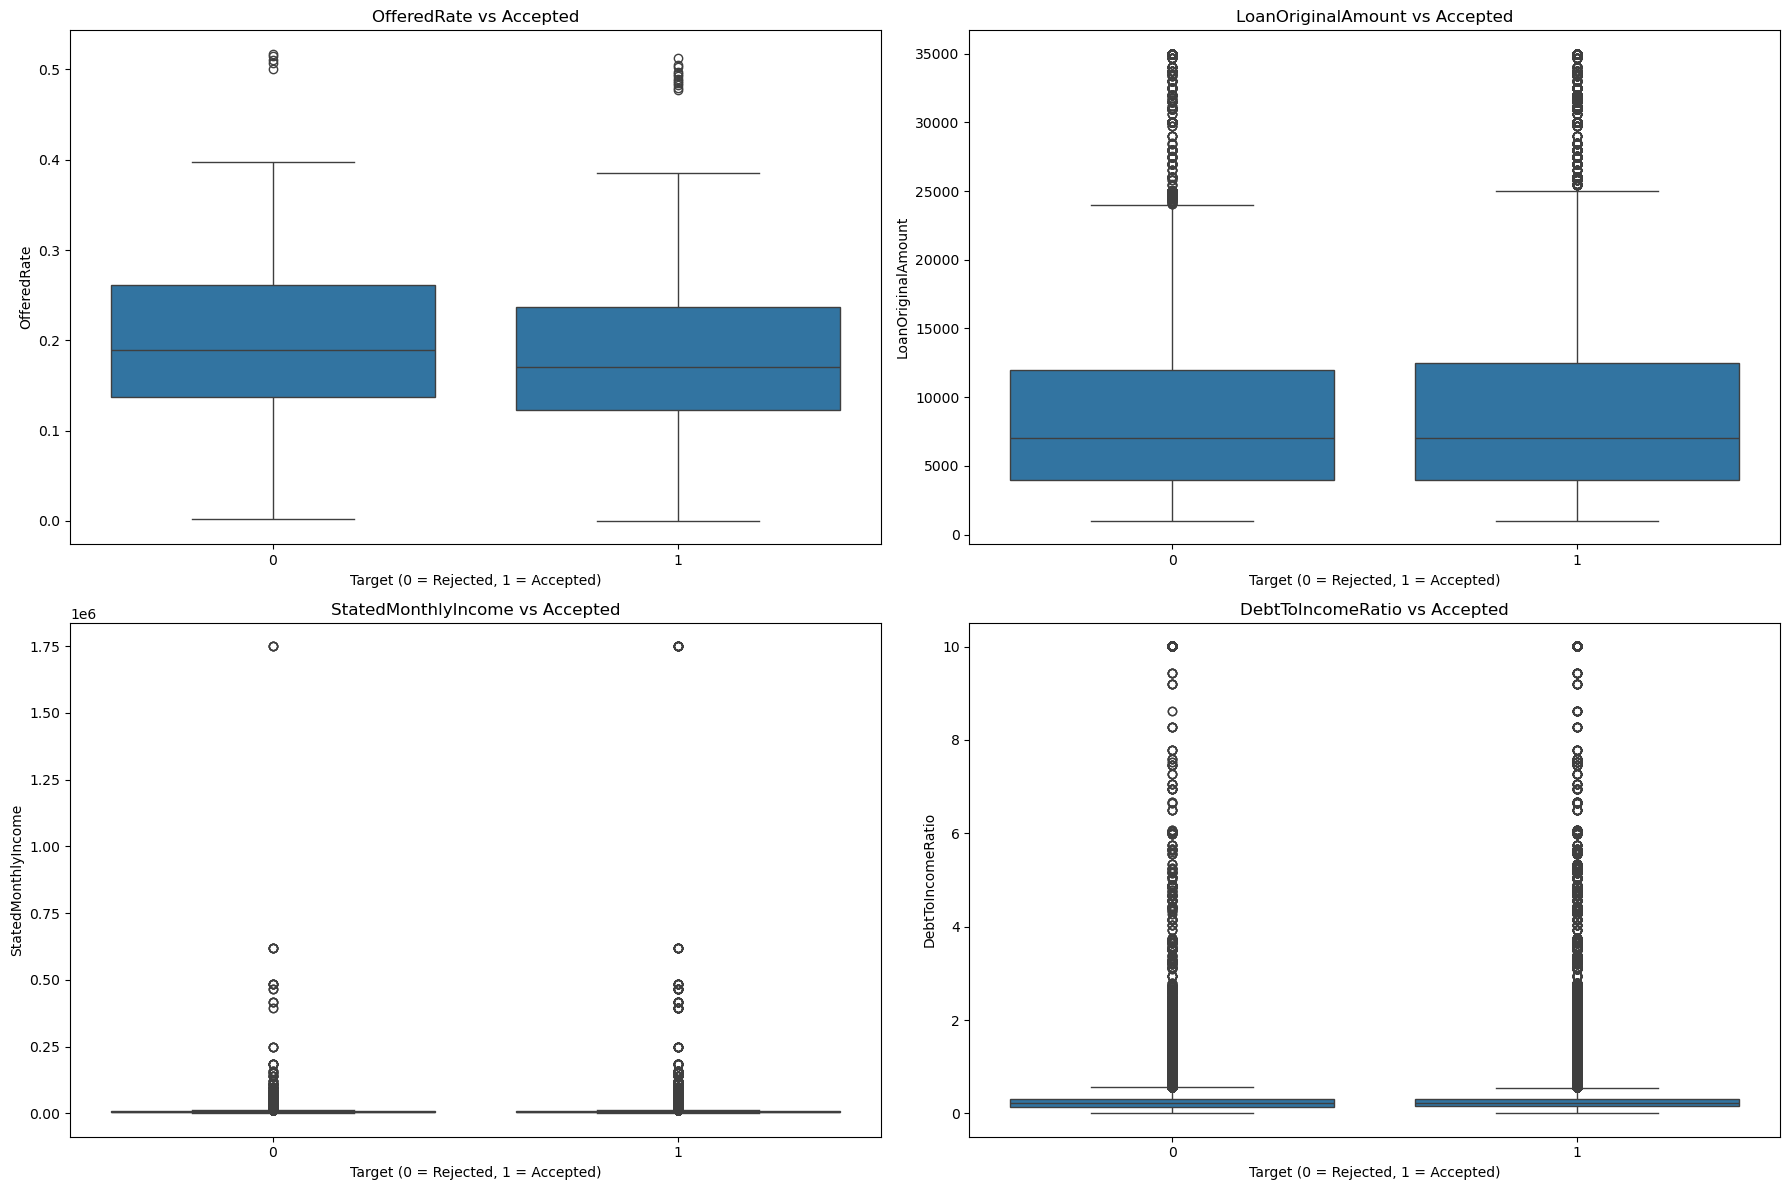

In [9]:
num_cols = [
    "OfferedRate",
    "LoanOriginalAmount",
    "StatedMonthlyIncome",
    "DebtToIncomeRatio",
]
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x="Accepted", y=col, data=synthetic_df, ax=axes[i])
    axes[i].set_title(f"{col} vs Accepted")
    axes[i].set_xlabel("Target (0 = Rejected, 1 = Accepted)")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

#### OfferedRate vs Accepted (Top-Left)

**What we see**

* Median **OfferedRate is lower for Accepted (1)** than for Rejected (0)
* Rejected loans show:

  * Higher upper quartile
  * More extreme high-rate outliers

**Interpretation**

* Clear **negative relationship** between interest rate and acceptance
* This confirms your synthetic elasticity logic:

* The overlap is expected because acceptance is probabilistic, not deterministic

#### LoanOriginalAmount vs Accepted (Top-Right)

**What we see**

* Medians are **very similar** for Accepted and Rejected
* Accepted loans have:

  * Slightly higher upper tail
  * More large-loan outliers

**Interpretation**

* Loan amount **weakly influences acceptance**
* Borrowers do not strongly reject based on amount alone
* Larger loans may be slightly more likely accepted due to:

  * Higher income borrowers
  * Correlation with credit quality (ProsperScore)


#### StatedMonthlyIncome vs Accepted (Bottom-Left)

**What we see**

* Extreme right skew with massive outliers
* Most of the distribution compressed near the bottom
* Medians are close, but:

  * Accepted loans show slightly higher upper values

**Interpretation**

* Raw income is **hard to interpret without transformation**
* Outliers dominate scale → boxplot hides signal
* However:

  * Higher income borrowers are **slightly more likely accepted**

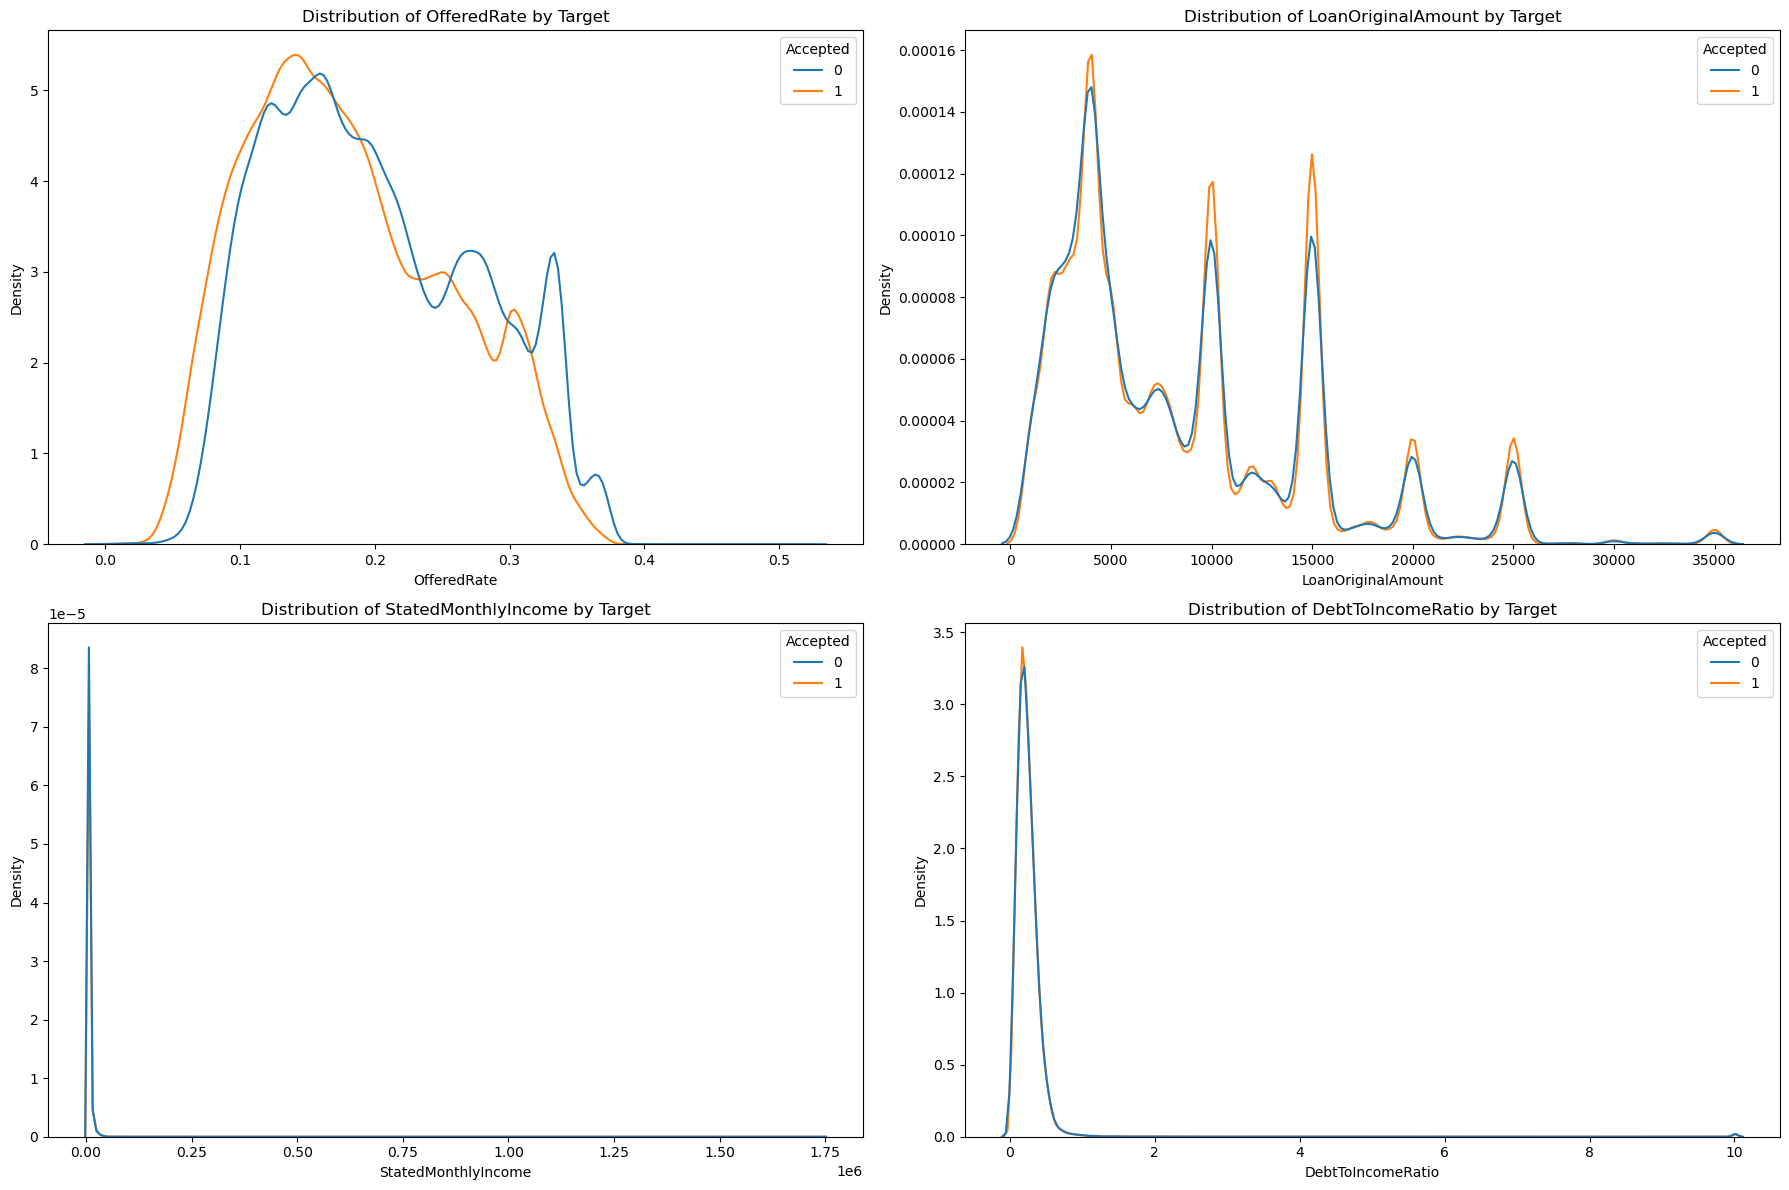

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=synthetic_df, x=col, hue="Accepted", ax=axes[i], common_norm=False)
    axes[i].set_title(f"Distribution of {col} by Target")
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()


#### OfferedRate by Target (Top-Left)

**What we see**

* Strong **left shift** for Accepted = 1
* Rejected = 0 has:

  * Higher density at **higher rates**
  * Longer right tail

**Interpretation**

* This is textbook **price elasticity behavior**
* At any given rate:

  * Acceptance probability declines as rate increases
* Overlap exists → realistic stochastic behavior

#### LoanOriginalAmount by Target (Top-Right)

**What we see**

* Almost identical shapes
* Slightly higher peaks for Accepted around certain amount buckets
* Multi-modal structure (loan size bands)

**Interpretation**

* Loan amount alone **does not strongly discriminate acceptance**
* Modal peaks reflect product design (e.g., $5k, $10k, $15k tiers)
* Any effect will be **interaction-based** (e.g., high loan + high rate)

#### StatedMonthlyIncome by Target (Bottom-Left)

**What we see**

* Extreme right skew
* Nearly perfect overlap between accepted and rejected
* Density compressed near zero due to scale

**Interpretation**

* Raw income provides **almost no visible separation**
* Heavy tails hide signal
* This feature is **non-linear and indirect**


#### DebtToIncomeRatio by Target (Bottom-Right)

**What we see**

* Accepted borrowers cluster at **lower DTI**
* Rejected borrowers show:

  * Wider spread
  * Heavier right tail

**Interpretation**

* Clear **risk sensitivity**
* Higher DTI → higher rejection likelihood
* Works as a **risk-moderated elasticity factor**

**Verdict**
* Strong secondary driver
* Important control variable to prevent adverse selection


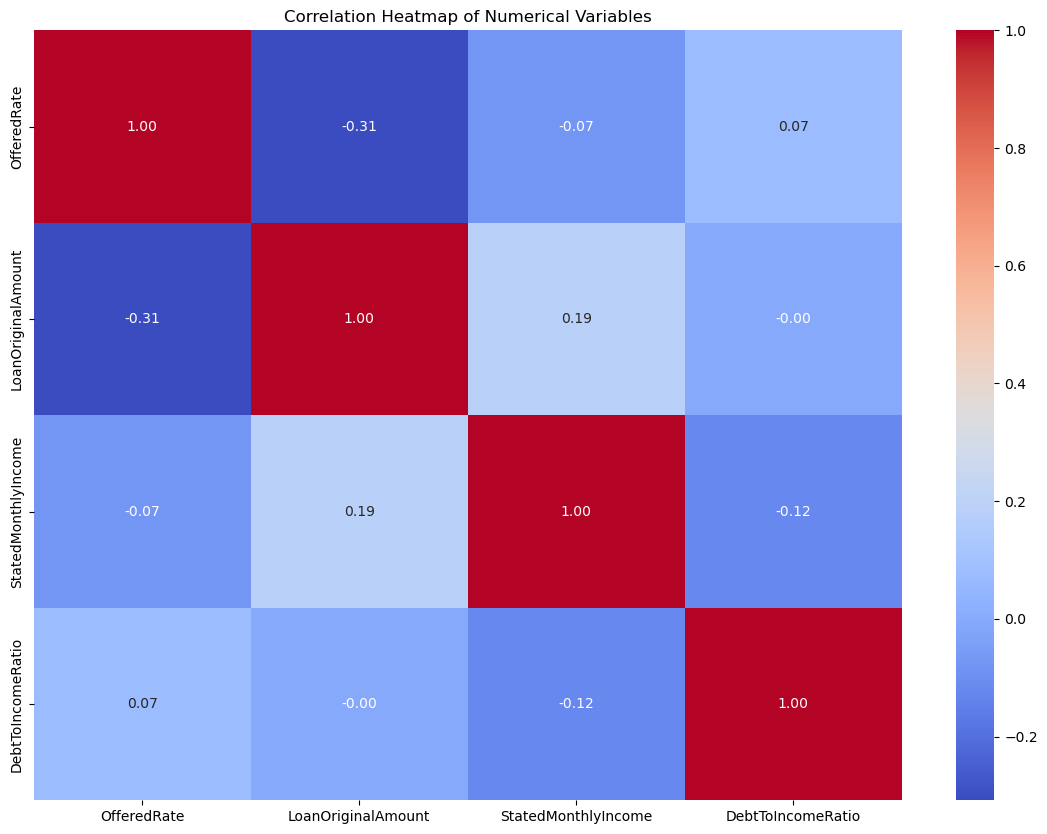

In [11]:
plt.figure(figsize=(14, 10))
corr = synthetic_df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

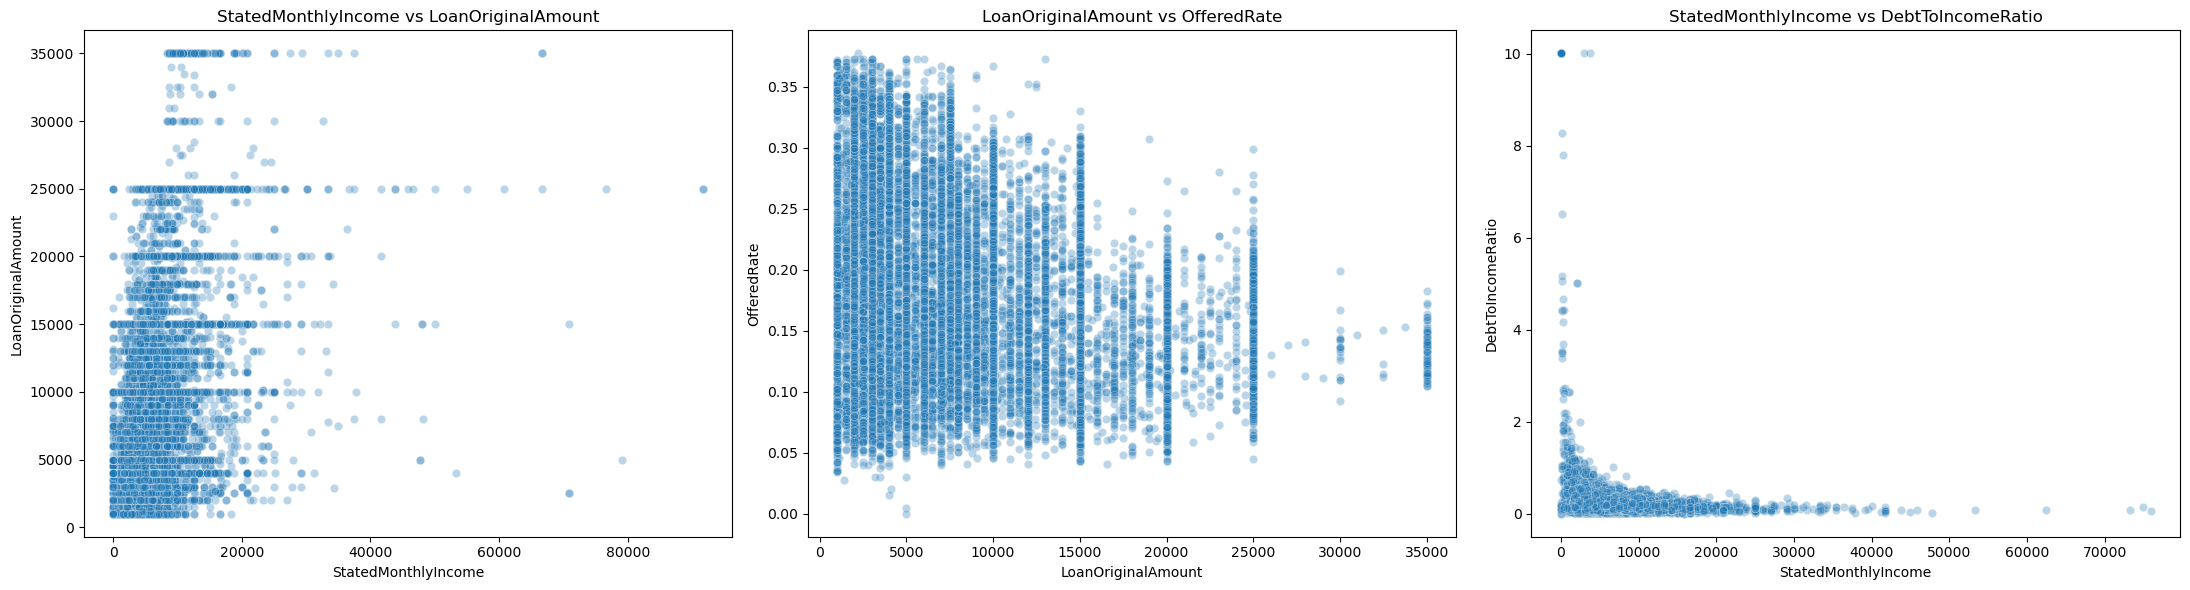

In [12]:
pairs = [
    ("StatedMonthlyIncome", "LoanOriginalAmount"),
    ("LoanOriginalAmount", "OfferedRate"),
    ("StatedMonthlyIncome", "DebtToIncomeRatio"),
]

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for i, (x, y) in enumerate(pairs):
    sns.scatterplot(x=x, y=y, data=synthetic_df.sample(20000), alpha=0.3, ax=axes[i])
    axes[i].set_title(f"{x} vs {y}")

plt.tight_layout()
plt.show()

C:\Users\parth\AppData\Local\Temp\ipykernel_26468\4036450840.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("rate_bin")["Accepted"]


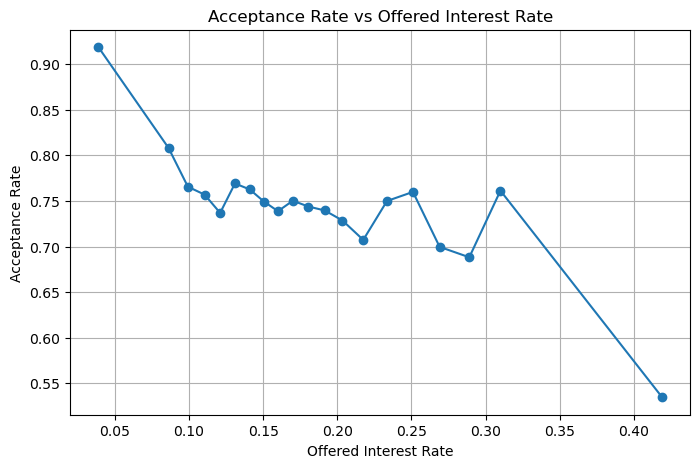

In [ ]:
# Bin OfferedRate
synthetic_df["rate_bin"] = pd.qcut(synthetic_df["OfferedRate"], q=20, duplicates="drop")

rate_curve = synthetic_df.groupby("rate_bin")["Accepted"].mean().reset_index()

# Extract bin midpoints for plotting
rate_curve["rate_mid"] = rate_curve["rate_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(8, 5))
plt.plot(rate_curve["rate_mid"], rate_curve["Accepted"], marker="o")
plt.xlabel("Offered Interest Rate")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate vs Offered Interest Rate")
plt.grid(True)
plt.show()

In [ ]:
synthetic_df["risk_band"] = pd.cut(
    synthetic_df["ProsperScore"],
    bins=[0, 4, 7, 11],
    labels=["High Risk", "Medium Risk", "Low Risk"],
)

C:\Users\parth\AppData\Local\Temp\ipykernel_26468\1320419794.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
C:\Users\parth\AppData\Local\Temp\ipykernel_26468\1320419794.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
C:\Users\parth\AppData\Local\Temp\ipykernel_26468\1320419794.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

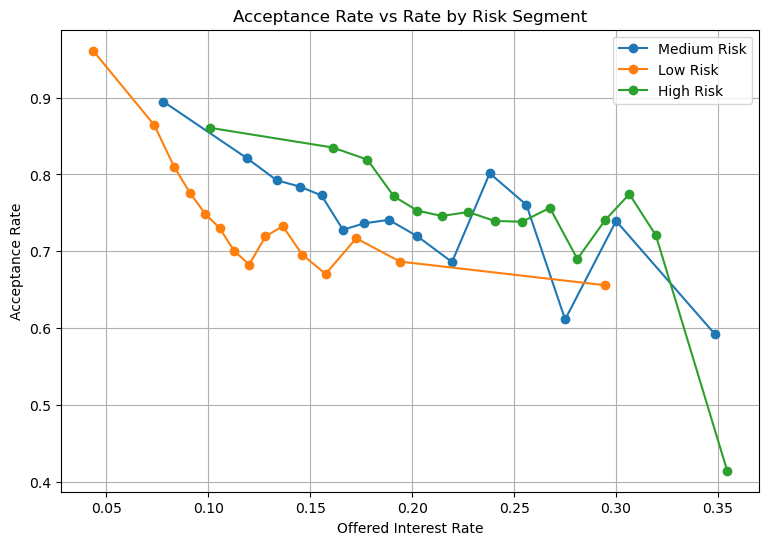

In [ ]:
plt.figure(figsize=(9, 6))

for band in synthetic_df["risk_band"].dropna().unique():
    temp = synthetic_df[synthetic_df["risk_band"] == band]
    curve = (
        temp.groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
        .mean()
        .reset_index()
    )
    curve["rate_mid"] = curve.iloc[:, 0].apply(lambda x: x.mid)
    plt.plot(curve["rate_mid"], curve["Accepted"], marker="o", label=band)

plt.xlabel("Offered Interest Rate")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate vs Rate by Risk Segment")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\parth\AppData\Local\Temp\ipykernel_26468\3909577091.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
C:\Users\parth\AppData\Local\Temp\ipykernel_26468\3909577091.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
C:\Users\parth\AppData\Local\Temp\ipykernel_26468\3909577091.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

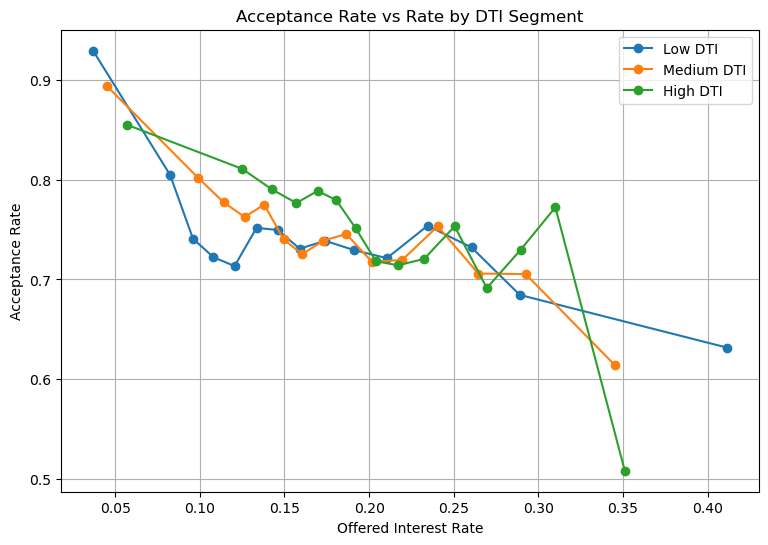

In [ ]:
synthetic_df["DTI_band"] = pd.cut(
    synthetic_df["DebtToIncomeRatio"],
    bins=[0, 0.2, 0.35, 1.0],
    labels=["Low DTI", "Medium DTI", "High DTI"],
)

plt.figure(figsize=(9, 6))

for band in synthetic_df["DTI_band"].dropna().unique():
    temp = synthetic_df[synthetic_df["DTI_band"] == band]
    curve = (
        temp.groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
        .mean()
        .reset_index()
    )
    curve["rate_mid"] = curve.iloc[:, 0].apply(lambda x: x.mid)
    plt.plot(curve["rate_mid"], curve["Accepted"], marker="o", label=band)

plt.xlabel("Offered Interest Rate")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate vs Rate by DTI Segment")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\parth\AppData\Local\Temp\ipykernel_26468\2623009818.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mono_rate = synthetic_df.groupby(rate_bins)["Accepted"].mean()


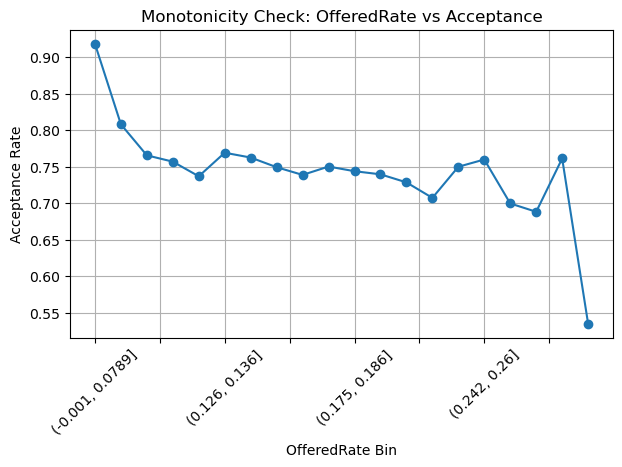

In [ ]:
rate_bins = pd.qcut(synthetic_df["OfferedRate"], 20, duplicates="drop")
mono_rate = synthetic_df.groupby(rate_bins)["Accepted"].mean()

plt.figure(figsize=(7, 4))
mono_rate.plot(marker="o")
plt.title("Monotonicity Check: OfferedRate vs Acceptance")
plt.ylabel("Acceptance Rate")
plt.xlabel("OfferedRate Bin")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

C:\Users\parth\AppData\Local\Temp\ipykernel_26468\2791110181.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mono_dti = synthetic_df.groupby(dti_bins)["Accepted"].mean()


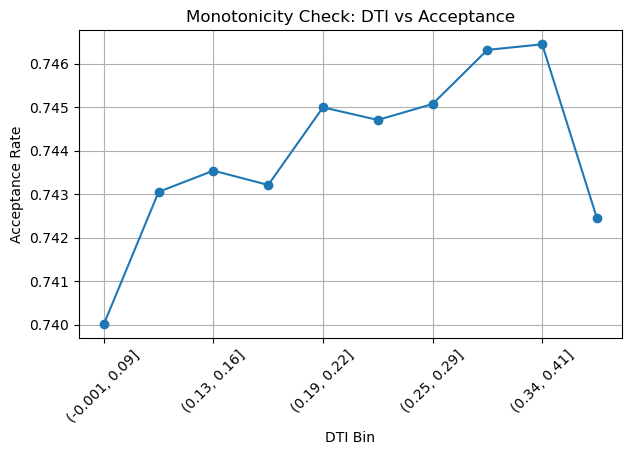

In [ ]:
dti_bins = pd.qcut(synthetic_df["DebtToIncomeRatio"], 10, duplicates="drop")
mono_dti = synthetic_df.groupby(dti_bins)["Accepted"].mean()

plt.figure(figsize=(7, 4))
mono_dti.plot(marker="o")
plt.title("Monotonicity Check: DTI vs Acceptance")
plt.ylabel("Acceptance Rate")
plt.xlabel("DTI Bin")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

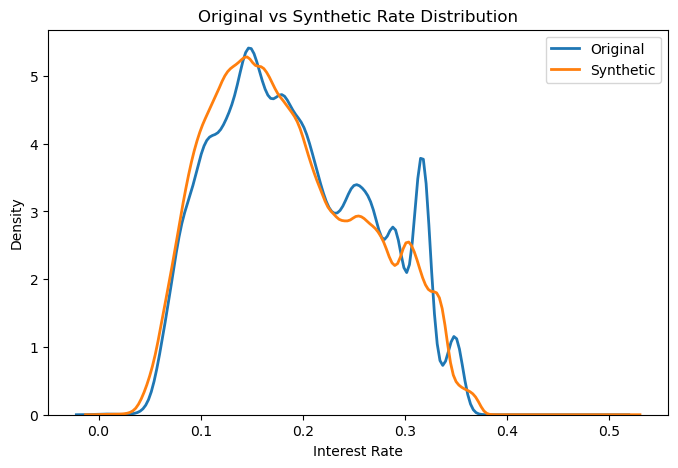

In [ ]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df["BorrowerRate"], label="Original", linewidth=2)
sns.kdeplot(synthetic_df["OfferedRate"], label="Synthetic", linewidth=2)

plt.title("Original vs Synthetic Rate Distribution")
plt.xlabel("Interest Rate")
plt.legend()
plt.show()

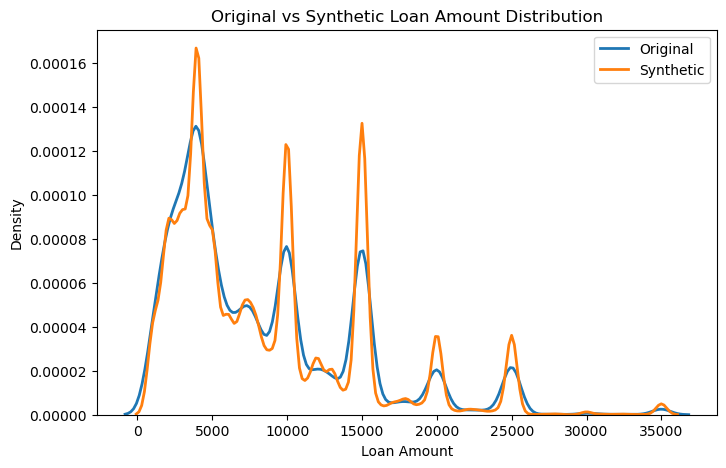

In [ ]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df["LoanOriginalAmount"], label="Original", linewidth=2)
sns.kdeplot(synthetic_df["LoanOriginalAmount"], label="Synthetic", linewidth=2)

plt.title("Original vs Synthetic Loan Amount Distribution")
plt.xlabel("Loan Amount")
plt.legend()
plt.show()

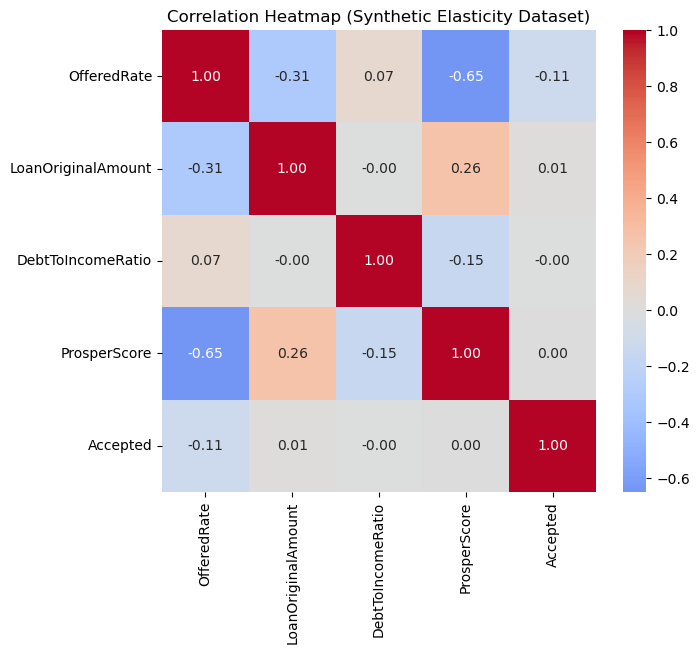

In [ ]:
numeric_cols = [
    "OfferedRate",
    "LoanOriginalAmount",
    "DebtToIncomeRatio",
    "ProsperScore",
    "Accepted",
]

plt.figure(figsize=(7, 6))
sns.heatmap(
    synthetic_df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0
)
plt.title("Correlation Heatmap (Synthetic Elasticity Dataset)")
plt.show()